In [109]:
import torch # type: ignore
import torch.nn.functional as F # type: ignore
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
words = open("names.txt", "r").read().splitlines()
len(words)

32033

In [10]:
chars = sorted(set("".join(words)))
chars

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [41]:
c_to_idx = {c: i+1 for i, c in enumerate(chars)}
c_to_idx["."] = 0

idx_to_c = {i: c for c, i in c_to_idx.items()}

In [42]:
bigram_counts = torch.zeros((27, 27), dtype=torch.int32)
for word in words:
    word = ["."] + list(word) + ["."]
    for c1, c2 in zip(word, word[1:]): # creating bigrams
        bigram_counts[c_to_idx[c1], c_to_idx[c2]] += 1

(-0.5, 26.5, 26.5, -0.5)

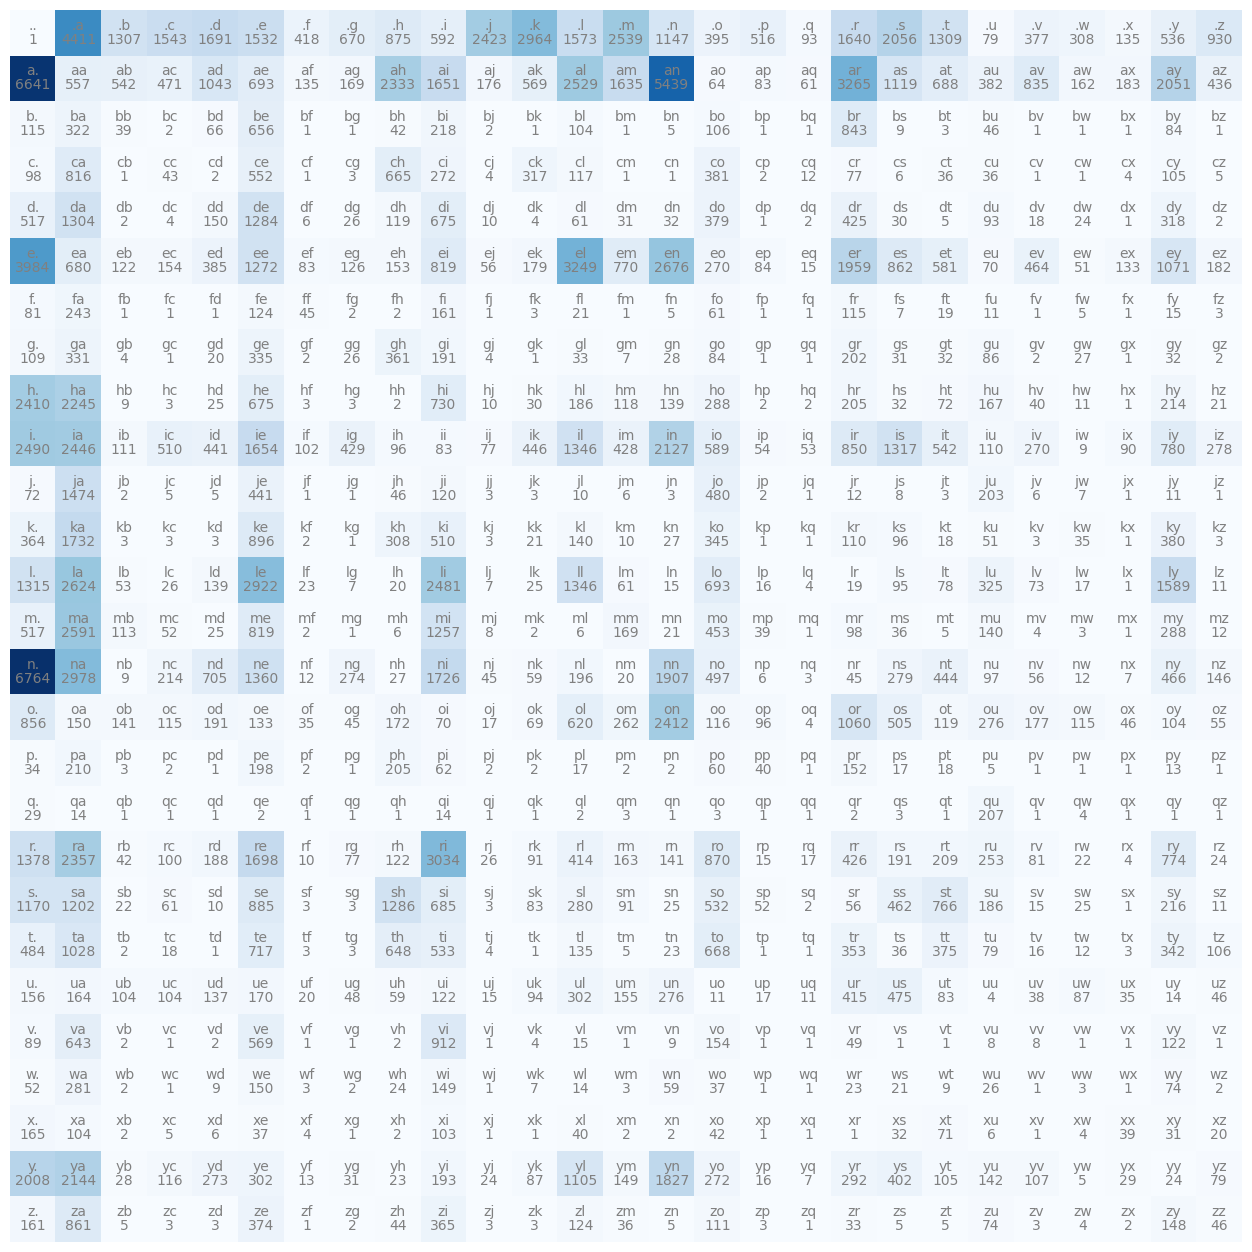

In [98]:
smoothed_bc = bigram_counts + 1

plt.figure(figsize=(16, 16))
plt.imshow(smoothed_bc, cmap="Blues")
for i in range(27):
    for j in range(27):
        display_str = f"{idx_to_c[i]}{idx_to_c[j]}"
        plt.text(j, i, display_str, ha="center", va="bottom", color="gray")
        plt.text(j, i, smoothed_bc[i, j].item(), ha="center", va="top", color="gray")
plt.axis("off")

In [99]:
prob_matrix = smoothed_bc / smoothed_bc.sum(axis=1, keepdim=True)
# bigram_counts: 27  27 
#                27   1 => broadcasting => 27  27
# need to use keep dim:
# if not:
# bigram_counts: 27  27 => 27  27 
# 27 => rightmost    27 =>  1  27 => broadcasting => 27  27
# dividing rows by column sums
# BROADCASTING: 
# LINE UP TRAILING DIMENSIONS
# ITERATE OVER DIMENSION SIZES
# https://pytorch.org/docs/stable/notes/broadcasting.html
# Respect it. Otherwise there will be a lot of subtle and difficult to find bugs
prob_matrix.sum(axis=1, keepdim=True)

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]])

In [100]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(5):
    outs = []
    current_idx = 0
    while True:
        next_char_probs = prob_matrix[current_idx]
        next_char_idx = torch.multinomial(next_char_probs, num_samples=1, replacement=True, generator=g)
        next_char = idx_to_c[next_char_idx.item()]
        outs.append(next_char)
        
        if next_char == ".":
            break
        else:
            current_idx = next_char_idx.item()
    print("".join(outs))

junide.
janasah.
p.
cony.
a.


In [105]:
# the prob_matrix is effectively the model in this case

log_probs = []
for word in ["laura", "lee", "khan"]:
    word = ["."] + list(word) + ["."]
    for c1, c2 in zip(word, word[1:]):
        bigram_prob = prob_matrix[c_to_idx[c1], c_to_idx[c2]]
        log_prob = torch.log(bigram_prob)
        log_probs.append(log_prob)
        # print(f"{c1}{c2}: {bigram_prob:.4f} {log_prob:.4f}")
        
# log(a*b*c) = log(a) + log(b) + log(c)
# avg: makes it easier to compare across datasets of differing sizes
log_likelihood = sum(log_probs) / len(log_probs)
neg_log_likelihood = -log_likelihood
print(f"{neg_log_likelihood=}") 
# maximize log likelihood. maximum value would be 0. due to the way the log function is defined
# minimize neg log likelihood. minimum value would be 0. when prob of the expected word in 1.0, then log prob is 0. if it's less than that then the log prob (neg'd) is going to be a positive number. the worse, the prediction, the larger that value

neg_log_likelihood=tensor(2.1833)


In [48]:
p = torch.rand(3, generator=g)
p = p / p.sum()
p

tensor([0.6064, 0.3033, 0.0903])

In [49]:
torch.multinomial(p, num_samples=20, replacement=True, generator=g)

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [106]:
xs, ys = [], []

for word in words[:1]:
    word_mod = ["."] + list(word) + ["."]
    for c1, c2 in zip(word_mod, word_mod[1:]):
        xs.append(c_to_idx[c1])
        ys.append(c_to_idx[c2])
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)

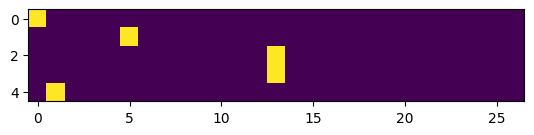

In [113]:
xenc = F.one_hot(xs, num_classes=27).float()
plt.imshow(xenc)

In [136]:
g = torch.Generator().manual_seed(2147483647)

# dot product between row vector of xenc & W. we want to pass this input into not just a single neuron. using a matrix of vectors specifying linear combinations. 
W = torch.randn((27, 27), generator=g) 

# log counts. the output of the model is going to be 27 numbers. given an one-hot encoded character (a-z&.), we want a probability distribution of what could be the next character. that's the interpretation we're going for
logits = (xenc @ W) 

# e^(log(counts)) = counts [natural log being used]
counts = logits.exp() 
# probs - respect broadcasting (dangerous, very subtle bugs that can be really hard to debug)
probs = counts / counts.sum(axis=1, keepdim=True)

# exp & normalization are known as softmax - takes in logits, gets counts, and then gets frequencies of those counts. 
# basically a normalization function. Larger values are amplified and have a greater probability. 

In [ ]:
# NOTE ALL OF THE OPERATIONS IN THE FORWARD PASS ABOVE ARE DIFFERENTIABLE. 

In [137]:
nlls = []
for i in range(5):
    x = xs[i].item()
    y = ys[i].item()
    
    print("--------------")
    print(f"bigram example {i+1}: {idx_to_c[x]}{idx_to_c[y]}")
    print(f"input to nn: {x}")
    # print(f"output probabilities of nn: {probs[i]}")
    
    print(f"expected output: {y}")
    print(f"prob of nn selecting correct output: {probs[i, y]}")
    
    # calculating error for loss - way too small. annoying to deal with and floating point imprecisions
    nlls.append(-torch.log(probs[i, y]))
    print(f"log likelihood: {-nlls[-1]}")
    print(f"neg log likelihood: {nlls}")

print("===================")
print(f"average neg log likelihood: {sum(nlls) / len(nlls)}")

--------------
bigram example 1: .e
input to nn: 0
expected output: 5
prob of nn selecting correct output: 0.01228625513613224
log likelihood: -4.399273872375488
neg log likelihood: [tensor(4.3993)]
--------------
bigram example 2: em
input to nn: 5
expected output: 13
prob of nn selecting correct output: 0.018050700426101685
log likelihood: -4.014570713043213
neg log likelihood: [tensor(4.3993), tensor(4.0146)]
--------------
bigram example 3: mm
input to nn: 13
expected output: 13
prob of nn selecting correct output: 0.026691533625125885
log likelihood: -3.623408794403076
neg log likelihood: [tensor(4.3993), tensor(4.0146), tensor(3.6234)]
--------------
bigram example 4: ma
input to nn: 13
expected output: 1
prob of nn selecting correct output: 0.07367686182260513
log likelihood: -2.6080665588378906
neg log likelihood: [tensor(4.3993), tensor(4.0146), tensor(3.6234), tensor(2.6081)]
--------------
bigram example 5: a.
input to nn: 1
expected output: 0
prob of nn selecting correct ou

In [154]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)
# requires_grad indicates that you're intersted in calculating gradients

In [164]:
# forward pass
logits = (xenc @ W) 
counts = logits.exp() 
probs = counts / counts.sum(axis=1, keepdim=True)
loss = -probs[torch.arange(5), ys].log().mean()
loss

tensor(3.7092, grad_fn=<NegBackward0>)

In [162]:
W.grad = None # lack of gradient, same as 0
loss.backward()

In [163]:
W.grad # each neuron needs 27 connections from each input
# reason on why there are so many zeros is because the one hot encoding has a lot of zeros for values that are never involved. there's only .emma., so there's 27-4 vector components that are zero across every input 
W.data += -0.1 * W.grad

## Putting it all Together

In [170]:
# Construct Dataset
xs, ys = [], []

for word in words:
    word_mod = ["."] + list(word) + ["."]
    for c1, c2 in zip(word_mod, word_mod[1:]):
        xs.append(c_to_idx[c1])
        ys.append(c_to_idx[c2])
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)

# Initialize Network
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [172]:
# Training Loop
alpha = 50
for i in range(100):
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(axis=1, keepdim=True)
    
    loss = -probs[torch.arange(len(xenc)), ys].log().mean()
    print(loss)
    
    # flushing gradients
    W.grad = None 
    loss.backward()
    
    # update gradients
    W.data -= alpha * W.grad # type: ignore

tensor(2.4727, grad_fn=<NegBackward0>)
tensor(2.4724, grad_fn=<NegBackward0>)
tensor(2.4722, grad_fn=<NegBackward0>)
tensor(2.4720, grad_fn=<NegBackward0>)
tensor(2.4718, grad_fn=<NegBackward0>)
tensor(2.4716, grad_fn=<NegBackward0>)
tensor(2.4714, grad_fn=<NegBackward0>)
tensor(2.4712, grad_fn=<NegBackward0>)
tensor(2.4710, grad_fn=<NegBackward0>)
tensor(2.4708, grad_fn=<NegBackward0>)
tensor(2.4707, grad_fn=<NegBackward0>)
tensor(2.4705, grad_fn=<NegBackward0>)
tensor(2.4703, grad_fn=<NegBackward0>)
tensor(2.4701, grad_fn=<NegBackward0>)
tensor(2.4700, grad_fn=<NegBackward0>)
tensor(2.4698, grad_fn=<NegBackward0>)
tensor(2.4697, grad_fn=<NegBackward0>)
tensor(2.4695, grad_fn=<NegBackward0>)
tensor(2.4693, grad_fn=<NegBackward0>)
tensor(2.4692, grad_fn=<NegBackward0>)
tensor(2.4690, grad_fn=<NegBackward0>)
tensor(2.4689, grad_fn=<NegBackward0>)
tensor(2.4687, grad_fn=<NegBackward0>)
tensor(2.4686, grad_fn=<NegBackward0>)
tensor(2.4685, grad_fn=<NegBackward0>)
tensor(2.4683, grad_fn=<N

In [ ]:
# There's very little information to work with. Fundamentally will perform about the same to the original counting approach. You only have access to one character, and you're trying to predict the next character. You really can't do any better than just taking the most likely next option. In this case, some randomness is needed. 

(-0.5, 26.5, 26.5, -0.5)

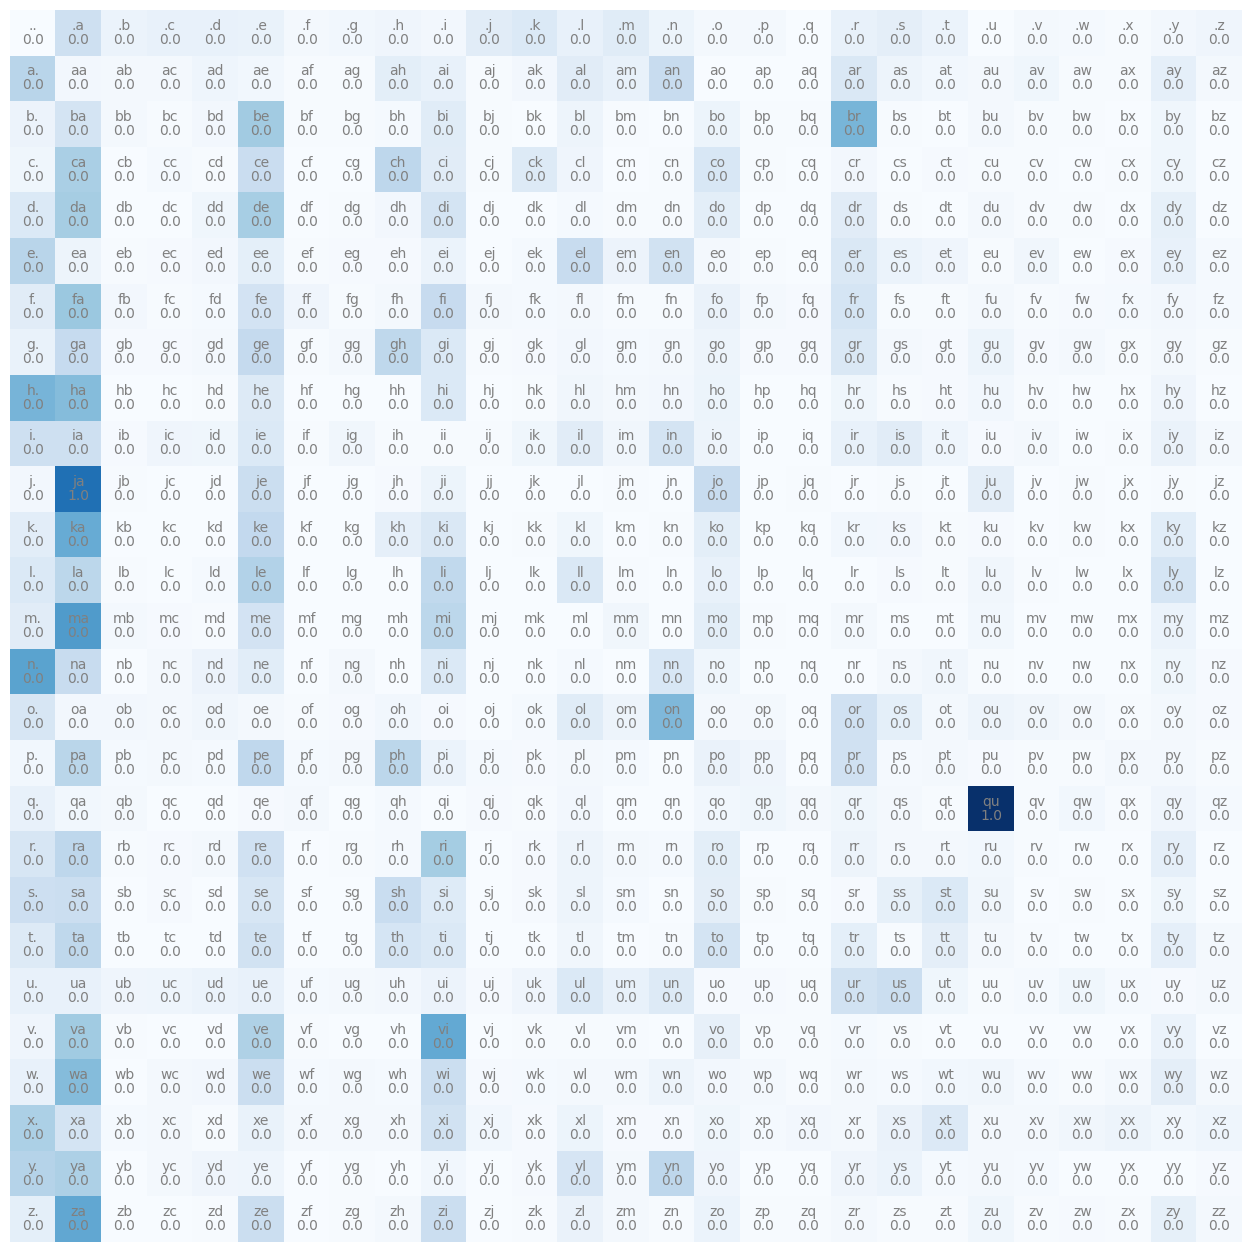

In [183]:
W_prob = W.data.exp() / W.data.exp().sum(axis=1, keepdim=True)
plt.figure(figsize=(16, 16))
plt.imshow(W_prob, cmap="Blues")
for i in range(27):
    for j in range(27):
        display_str = f"{idx_to_c[i]}{idx_to_c[j]}"
        plt.text(j, i, display_str, ha="center", va="bottom", color="gray")
        plt.text(j, i, round(W_prob[i, j].item(), 0), ha="center", va="top", color="gray")
plt.axis("off")

(-0.5, 26.5, 26.5, -0.5)

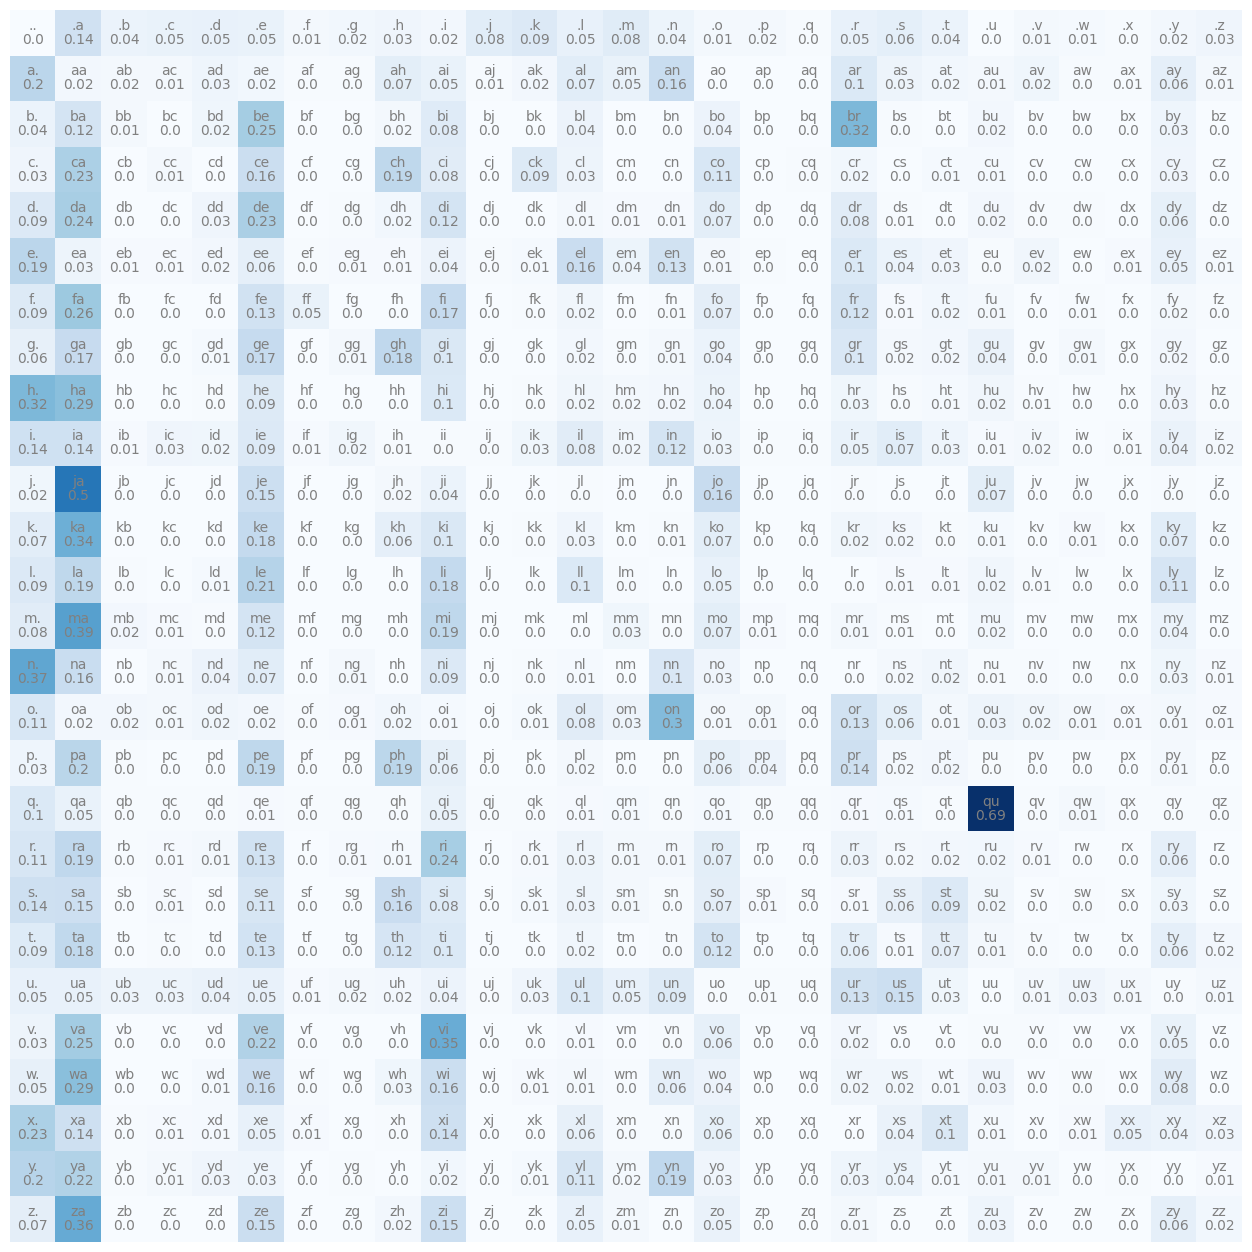

In [178]:
plt.figure(figsize=(16, 16))
plt.imshow(prob_matrix, cmap="Blues")
for i in range(27):
    for j in range(27):
        display_str = f"{idx_to_c[i]}{idx_to_c[j]}"
        plt.text(j, i, display_str, ha="center", va="bottom", color="gray")
        plt.text(j, i, round(prob_matrix[i, j].item(), 2), ha="center", va="top", color="gray")
plt.axis("off")